# Approach 2

In this approach, ever team is constructed using its better three players rating units. Prior initialization is performed using players as single rating units. Inference and prediction model are performed using teams rating units.

In [60]:
from trueskill import Rating
import trueskill as ts
import pandas as pd
import numpy as np
import scipy 
from scipy import stats
import itertools
import math
import random
import matplotlib.pyplot as plt
import operator

### Data reading and cleaning.

In [61]:
games2020, games2021 = read_clean_games()

ind_data2019 = ind_read_clean_data('2019_individual_stats.xls', order_by='PTS')
ind_data2020 = ind_read_clean_data('2020_individual_stats.xls', order_by='PTS')

team_data2019, team_data2020 = team_read_clean_data()

true_ranking_2019 = read_prepare_xls('team_ranking_2019.xls')
true_ranking_2020 = read_prepare_xls('team_ranking_2020.xls')
true_ranking_2021 = read_prepare_xls('team_ranking_2021.xls')

AvAge = ind_data2019.groupby(['Tm']).mean()['Age']


team_data2019 = team_data2019.sort_values('Team', ascending=True)
team_data2020 = team_data2020.sort_values('Team', ascending=True)

### 1. Prior initialization.

In [62]:
players_dic, teams_dic, teams_skills = prior_initialization_players(ind_data2019, approach=1)

#### Evaluation using metric measures.

Kendall tau correlation coefficient.

In [63]:
final_rank = prepare_ranking(teams_skills)
corr, pvalue = rank_distance(final_rank['Pos'], true_ranking_2019['Pos'])
print(corr)

0.016091954022988506


Normalized Kendall Tau distance.

In [64]:
fr = []
tr = []
for i in final_rank['Pos']: fr.append(i)

for i in true_ranking_2019['Pos']: tr.append(i)
    


kt_dist = normalised_kendall_tau_distance(fr, tr)
print(kt_dist)

0.3632183908045977


### 2. Inference process

In [65]:
games_outcome_2019 = prepare_arrays(games2020['HomeWinner'], games2020['AwayWinner'])
match_array_2019 = prepare_arrays(games2020['Home/Neutral'], games2020['Visitor/Neutral'])


teams_skills, sigma_evolution = inference(teams_skills, match_array_2019, games_outcome_2019, team_data2020)


#get final ranking
final_rank = prepare_ranking(teams_skills)

#### Evaluation using metric measures.

Kendall tau correlation coefficient.

In [66]:
corr, pvalue = rank_distance(final_rank['Pos'], true_ranking_2020['Pos'])
print(corr, pvalue)

0.25057471264367814 0.05344665404681452


Normalized Kendall Tau distance.

In [67]:
fr = []
tr = []
for i in final_rank['Pos']: fr.append(i)

for i in true_ranking_2020['Pos']: tr.append(i)
    


kt_dist = normalised_kendall_tau_distance(fr, tr)
print(kt_dist)

0.06206896551724138


Sigma evolution plot.

No handles with labels found to put in legend.


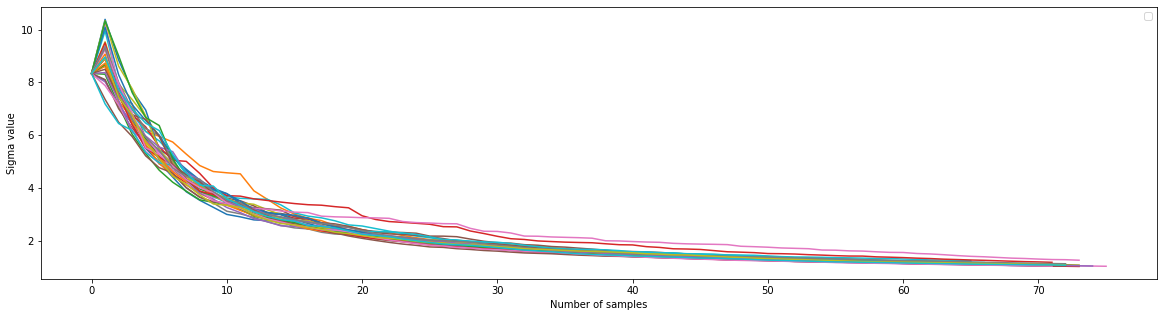

In [69]:
plt.figure(figsize=(20,5))
for team in sigma_evolution:
    plt.plot(range(0,len(sigma_evolution[team])), sigma_evolution[team])

plt.xlabel('Number of samples')
plt.ylabel('Sigma value')
plt.legend()
plt.show()

### 3. Prediction model

In [70]:
games_outcome_2020 = prepare_arrays(games2021['HomeWinner'], games2021['AwayWinner'])
match_array_2020 = prepare_arrays(games2021['Home/Neutral'], games2021['Visitor/Neutral'])


#prediction repeated over N iterations
iterations = 1000
mispredictions = []
ranking_correlations = []
ranking_distances = []
fr = []
tr = []
pred_teams_wins = prior_initialization_teams(team_data2020, approach=0)
n_wins = prior_initialization_teams(team_data2020, approach=0)
wins_difference = prior_initialization_teams(team_data2020, approach=0)

for team in pred_teams_wins:
    n_wins[team] = 0


for i in range(0, iterations):
    #simulate each game output
    games2021, ratio = season_simulation(teams_skills, match_array_2020, games2021)
    
    
    
    #compute rankings difference
    for team in pred_teams_wins:
        pred_teams_wins[team] = 0
        
    
    for i in range(len(match_array_2020)):
        
        if (games2021['Pred_Home'][i] == 0):
            
            pred_teams_wins[match_array_2020[i][0]] += 1
            
        if (games2021['Pred_Away'][i] == 0):
            
            pred_teams_wins[match_array_2020[i][1]] += 1
    
    
    
    #organizee data in order to perform ranking distance comparison
    count = 0
    for i in pred_teams_wins:
        count = count+1
        pred_teams_wins[i] = (pred_teams_wins.get(i), count)
    
    ranking = pd.DataFrame(pred_teams_wins).transpose()
    ranking.columns = ['wins','Pos']
    ranking = ranking.sort_values(by='wins', ascending=False)
    
    
    
    #compute evaluation metric measures.
    kt_dist = normalised_kendall_tau_distance(np.array(ranking['Pos']), np.array(true_ranking_2021['Pos']))
    
    rdist,_ = rank_distance(ranking['Pos'], true_ranking_2021['Pos'])
    
    for team in n_wins:
        n_wins[team] = n_wins[team]+pred_teams_wins[team][0]
    
    mispredictions.append(ratio)
    ranking_distances.append(kt_dist)
    ranking_correlations.append(rdist)
    

### 4. Results

Histogram representing the ratio of mispredicted games for each iteration. The mean over all iterations is displayed as a red dashed line.

54.74083333333333


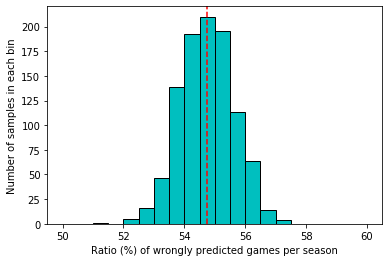

In [71]:
plt.hist(mispredictions, bins=20, range=[50,60], color='c', edgecolor='k')
plt.axvline(np.mean(mispredictions), color='red', linestyle='dashed')
plt.xlabel('Ratio (%) of wrongly predicted games per season')
plt.ylabel('Number of samples in each bin')
print(np.mean(mispredictions))

Histogram representing the normalized Kendall Tau distance between ground truth and predicted rankings for each iteration. The mean over all iterations is displayed as a red dashed line.

0.3798620689655172


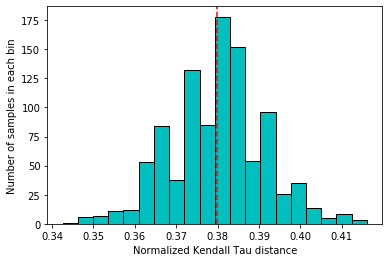

In [72]:
plt.hist(ranking_distances, bins=20, color='c', edgecolor='k')
plt.axvline(np.mean(ranking_distances), color='red', linestyle='dashed')
plt.xlabel('Normalized Kendall Tau distance')
plt.ylabel('Number of samples in each bin')
print(np.mean(ranking_distances))

Histogram representing the Kendall Tau correlation coefficient computed for ground truth and predicted rankings for each iteration. The mean over all iterations is displayed as a red dashed line.

0.06684137931034484


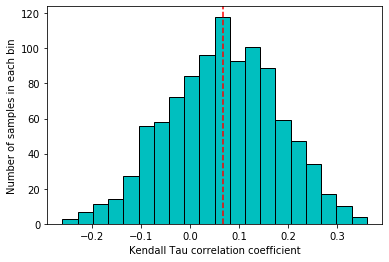

In [73]:
plt.hist(ranking_correlations, bins=20, color='c', edgecolor='k')
plt.axvline(np.mean(ranking_correlations), color='red', linestyle='dashed')
plt.xlabel('Kendall Tau correlation coefficient')
plt.ylabel('Number of samples in each bin')
print(np.mean(ranking_correlations))

This histogram represents the average amount of games won per team.

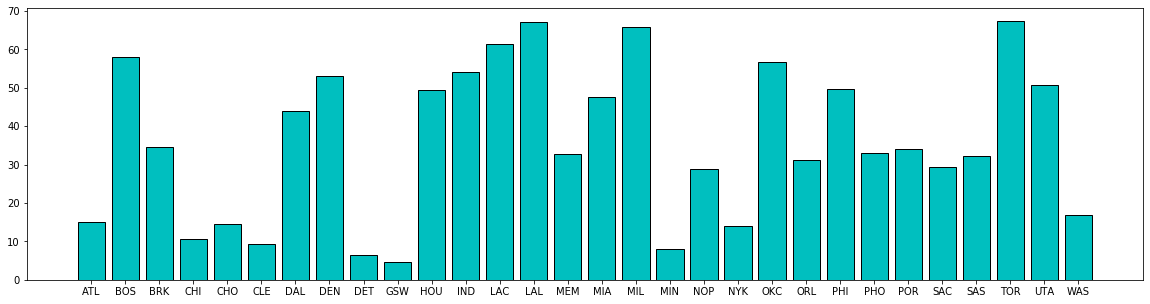

In [74]:
real_win = {}
for team in n_wins:
    n_wins[team] = n_wins[team]/iterations
    real_win[team] = int(true_ranking_2021[true_ranking_2021['Team']==team]['W'])
    
    
plt.figure(figsize=(20,5))
plt.bar(range(len(n_wins)), list(n_wins.values()), tick_label=list(n_wins.keys()), color='c', edgecolor='k')
plt.show()

Histogram representing the average amount of games won (blue bars) against the grount truth amount of games won (green bars) for each team. 

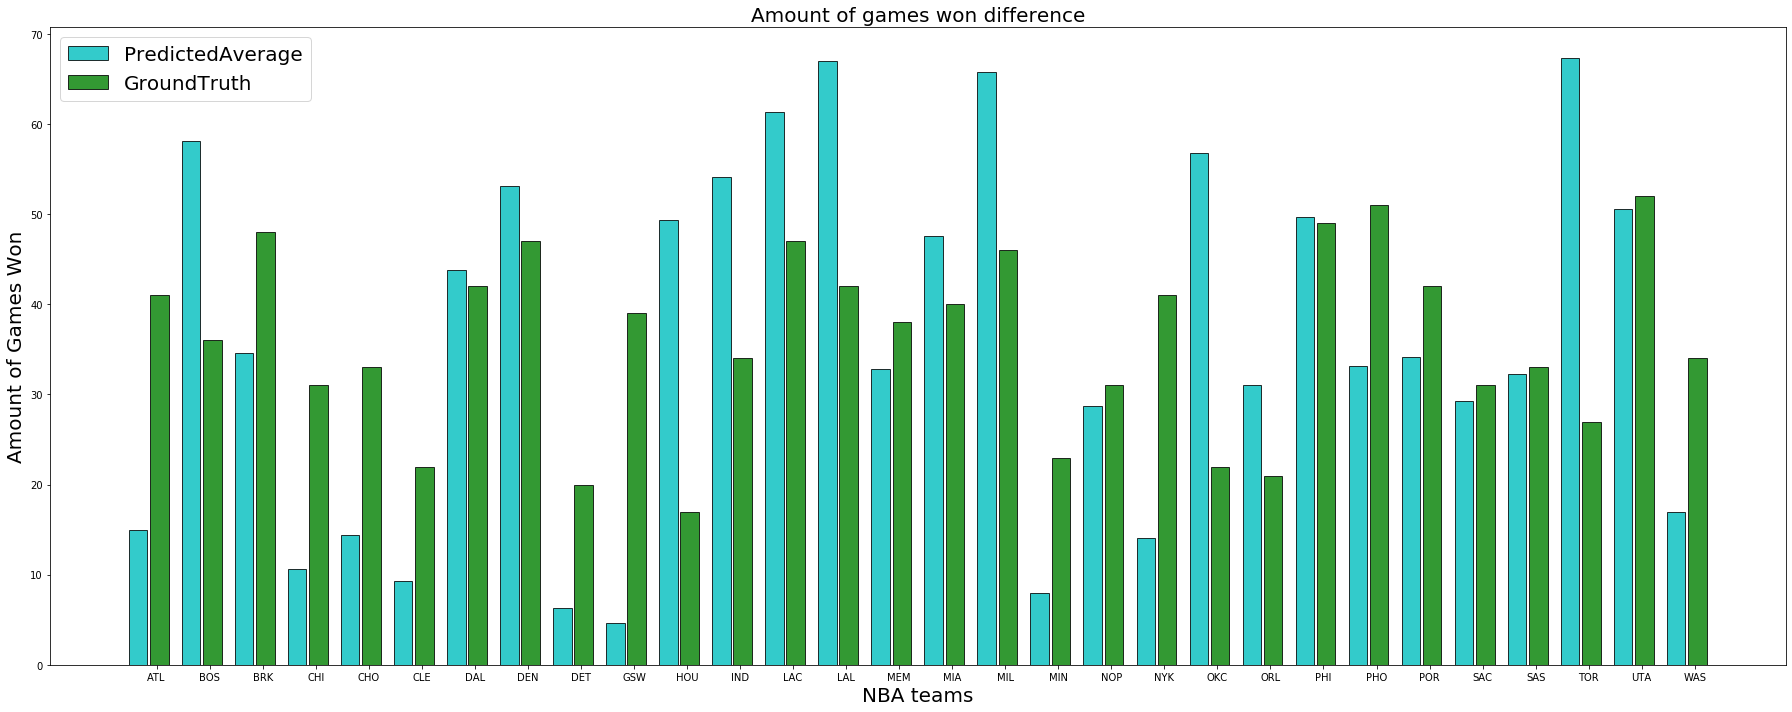

In [76]:
plt.figure(figsize=(25,10))
index = np.arange(len(n_wins))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, list(n_wins.values()), bar_width,
                alpha=opacity,
                color='c',
                edgecolor='k',
                label='PredictedAverage')

rects2 = plt.bar(index + bar_width+0.05, list(real_win.values()), bar_width,
                 alpha=opacity,
                 color='g',
                 edgecolor='k',
                 label='GroundTruth')



plt.xlabel('NBA teams', size=20)
plt.ylabel('Amount of Games Won', size=20)
plt.title('Amount of games won difference', size=20)
plt.xticks(index + bar_width, list(n_wins.keys()))
plt.legend(loc=2, prop={'size': 20})

plt.tight_layout()
plt.show()

Average difference between the predicted amount of games won and the ground truth amount of games won among all teams.

In [40]:
for team in n_wins:
    wins_difference[team] = abs(n_wins[team]-real_win[team])
    

avdif = 0
for i in wins_difference:
    avdif = avdif+wins_difference[i]
    
avdif = avdif/len(wins_difference)
avdif

15.693333333333339

### Auxiliar functions.

In [44]:
# This function is used to prepare and clean data corresponding to each game in seasons 2019/2020 and
# 2020/2021. Each database is returned separatelly, one for each season. For each row (game) there are
# 4 columns (one for each team involved in the game, and two binary complementary columns). Binary
# complementary columns are named AwayWinner and HomeWinner. For each row, if the home team wins the game, 
# HomeWinner is set to 0, whereas AwayWinner to 1.


def read_clean_games():
    #read games over the season
    games2020oct = pd.read_csv('Games2020oct.csv', sep=';')
    games2020nov = pd.read_csv('Games2020nov.csv', sep=';')
    games2020dec = pd.read_csv('Games2020dec.csv', sep=';')
    games2020jan = pd.read_csv('Games2020jan.csv', sep=';')
    games2020feb = pd.read_csv('Games2020feb.csv', sep=';')
    games2020mar = pd.read_csv('Games2020mar.csv', sep=';')
    games2020jul = pd.read_csv('Games2020jul.csv', sep=';')
    games2020aug = pd.read_csv('Games2020aug.csv', sep=';')
    
    #games databases were separated by month each took place in, so I needed to concatenate them in a single db.
    games2020 = pd.concat([games2020oct, games2020nov], axis=0)
    games2020 = pd.concat([games2020, games2020dec], axis=0)
    games2020 = pd.concat([games2020, games2020jan], axis=0)
    games2020 = pd.concat([games2020, games2020feb], axis=0)
    games2020 = pd.concat([games2020, games2020mar], axis=0)
    games2020 = pd.concat([games2020, games2020jul], axis=0)
    games2020 = pd.concat([games2020, games2020aug], axis=0)
    
    # winner set to 0 if local team wins, loser to 1
    #low ranking is better in trueskill.

    games2020['AwayWinner'] = np.where(games2020['PTS.1']<games2020['PTS'], 0, 1)
    games2020['HomeWinner'] = np.where(games2020['PTS']<games2020['PTS.1'], 0, 1)

    games2020 = games2020.drop(columns=['Date','Start (ET)','PTS','PTS.1','Unnamed: 6','Unnamed: 7','Attend.','Notes'])
    
    games2020.dropna(inplace=True)
    games2020.reset_index(inplace=True, drop=True)
    
    name_to_code(games2020['Visitor/Neutral'])
    name_to_code(games2020['Home/Neutral'])
    
    
    ##############################################################
    
    games2021dec = pd.read_csv('Games2021dec.csv', sep=';')
    games2021jan = pd.read_csv('Games2021jan.csv', sep=';')
    games2021feb = pd.read_csv('Games2021feb.csv', sep=';')
    games2021mar = pd.read_csv('Games2021mar.csv', sep=';')
    games2021apr = pd.read_csv('Games2021apr.csv', sep=';')
    games2021may = pd.read_csv('Games2021may.csv', sep=';')


    #games databases were separated by month each took place in, so I needed to concatenate them in a single db.
    games2021 = pd.concat([games2021dec, games2021jan], axis=0)
    games2021 = pd.concat([games2021, games2021feb], axis=0)
    games2021 = pd.concat([games2021, games2021mar], axis=0)
    games2021 = pd.concat([games2021, games2021apr], axis=0)
    games2021 = pd.concat([games2021, games2021may], axis=0)



    # winner set to 1 if local team wins, loser to 0
    games2021['AwayWinner'] = np.where(games2021['PTS.1']<games2021['PTS'], 0, 1)
    games2021['HomeWinner'] = np.where(games2021['PTS']<games2021['PTS.1'], 0, 1)

    games2021 = games2021.drop(columns=['Date','Start (ET)','PTS','PTS.1','Unnamed: 6','Unnamed: 7','Attend.','Notes'])

    games2021.dropna(inplace=True)
    games2021.reset_index(inplace=True, drop=True)

    name_to_code(games2021['Visitor/Neutral'])
    name_to_code(games2021['Home/Neutral'])
    
    
    return games2020, games2021

In [45]:
# This function receives as parameter a column of a dataframe, converts the complete team name by its 
# code, and then the same column is returned.


def name_to_code(column):
    
    
    return column.replace({'Atlanta Hawks':'ATL', 'Boston Celtics':'BOS', 
                                                     'Brooklyn Nets':'BRK', 'Chicago Bulls':'CHI',
                                                     'Charlotte Hornets':'CHO', 'Cleveland Cavaliers':'CLE',
                                                     'Dallas Mavericks':'DAL', 'Denver Nuggets':'DEN',
                                                     'Detroit Pistons':'DET', 'Golden State Warriors':'GSW',
                                                     'Houston Rockets':'HOU', 'Indiana Pacers':'IND',
                                                     'Los Angeles Clippers':'LAC', 'Los Angeles Lakers':'LAL',
                                                     'Memphis Grizzlies':'MEM', 'Miami Heat':'MIA',
                                                     'Milwaukee Bucks':'MIL', 'Minnesota Timberwolves':'MIN',
                                                     'New Orleans Pelicans':'NOP', 'New York Knicks':'NYK',
                                                     'Oklahoma City Thunder':'OKC', 'Orlando Magic':'ORL',
                                                     'Philadelphia 76ers':'PHI', 'Phoenix Suns':'PHO',
                                                     'Portland Trail Blazers':'POR', 'Sacramento Kings':'SAC',
                                                     'San Antonio Spurs':'SAS', 'Toronto Raptors':'TOR',
                                                     'Utah Jazz':'UTA', 'Washington Wizards':'WAS'}, inplace=True)




In [46]:
# This function reads and cleans individual players databases. NaN values are replaced by 0, and after it,
# rows for which 'Player' value is the same (and thus are duplicates) are deleted except the last one.
# Duplicate players means that the player was transfered during the season, and thus had two rows of 
# statistics, one for each team in which he played for.
# Then data is grouped by team code. Only three players per team are saved. Finally the dataset is returned.


def ind_read_clean_data(filename, order_by):
    
    data = pd.read_excel(filename, index_col=0)
    data = data.fillna(0)
    data = data.drop_duplicates(['Player'], keep='last')
    data = data.sort_values(['Tm', order_by], ascending=[True, False])
    data = data.reset_index(drop=True)
    
    data = data.groupby(['Tm']).head(3)
    
    return data

In [47]:
# This function reads and cleans team data statistics for seasons 2018/2019 and 2019/2020.


def team_read_clean_data():
    
    data = pd.read_csv('teamstats2019.csv', sep=';')
    data = data.drop([30])
    data['Rk'] = data['Rk'].astype(int)
    name_to_code(data['Team'])
    
    data2 = pd.read_csv('teamstats2020.csv', sep=';')
    data2 = data2.drop([30])
    data2['Rk'] = data2['Rk'].astype(int)
    name_to_code(data2['Team'])
    
    
    
    return data, data2

In [48]:
# Prior initialization function. The function receives as parameters the dataset, and the approach in 
# which the user wants to perform prior initialization. Function returns a dictionary where every player 
# is intialized with a score, a dictionary where each team contains its players, and a dicitonary containing
# each teams' skills.


def prior_initialization_players(data, approach):
    
    players_dic = {}
    teams_dic = {}
    teams_skills = {}

    for player in data['Player']:
        
        if approach==0:
            players_dic[player] = Rating()
        
            
        if approach==1:    
            pts = data[data['Player']==player]['PTS']
            ast = data[data['Player']==player]['AST']
            rbd = data[data['Player']==player]['TRB']
            #pie = data[data['Player']==player]['PIE']
            #normal = 25
            
            par = 0.4*pts+0.3*ast+0.3*rbd

            mu = float(par)
            sigma = float(mu/2-(data[data['Player']==player]['Age']))

            players_dic[player] = Rating(mu, mu/3)



    for team in data['Tm']:

        teams_dic[team] = data[data['Tm']==team]['Player']



    for team in teams_dic:

        teams_skills[team] = Rating(0.0,0.00001)

        for player in teams_dic[team]:

            teams_skills[team] = Rating(players_dic[player].mu+teams_skills[team].mu ,
                                        players_dic[player].sigma+teams_skills[team].sigma)

    
    return players_dic, teams_dic, teams_skills

In [49]:
# This function is used to perform team initialization. The function receives a dataset and the approach
# used to perform prior initialization. The function returns the dictionary of each teams' skills.


def prior_initialization_teams(data, approach):
    
    teams_dic = {}
    
    #AvAge = ind_data2020.groupby(['Tm']).mean()['Age']
    
    for team in data['Team']:
        
        if approach==0:
            teams_dic[team] = Rating()
            
        if approach==1:        
            pts = data[data['Team'] == team]['PTS']
            ast = data[data['Team'] == team]['AST']
            rbd = data[data['Team'] == team]['TRB']

            #trustiness = AvAge[team]

            avskll = float(data[data['Team']==team]['PTS'])

            teams_dic[team] = Rating(avskll, avskll/3)
    
    return teams_dic

In [50]:
# This function receives as parameter the ground truth ranking. Teams are ordered by the number of wins
# and then the dataset is returned.


def read_prepare_xls(filename):
    data = pd.read_excel(filename, index_col=0)
    
    name_to_code(data['Team'])

    data = data.sort_values(by='Team', ascending=True)
    data['Pos']=[i+1 for i in range(len(data))]
    data = data.sort_values(by='W', ascending=False)
    
    return data

In [51]:
# This function receives as parameters two rankings and returns the Kendall Tau distance between them.


def normalised_kendall_tau_distance(values1, values2):
    """Compute the Kendall tau distance."""
    n = len(values1)
    assert len(values2) == n, "Both lists have to be of equal length"
    i, j = np.meshgrid(np.arange(n), np.arange(n))
    a = np.argsort(values1)
    b = np.argsort(values2)
    ndisordered = np.logical_or(np.logical_and(a[i] < a[j], b[i] > b[j]), np.logical_and(a[i] > a[j], b[i] < b[j])).sum()
    return ndisordered / (n * (n - 1))

In [52]:
# This function receives as parameters two rankings and returns the Kendall tau correlation coefficient
# between them.


def rank_distance(r1, r2):
    
    return scipy.stats.kendalltau(r1,r2, initial_lexsort=True)
    

In [53]:
# This function is used to compute skill for each team or player. It receives as parameters mu and sigma,
# and returns the skill.


def rating(mu, sigma):
    
    return mu-2*sigma

In [54]:
#  This function receives as parameters the dictionary of teams skills, and returns the ranking for such
# teams ordered by higher to lower rating value.


def prepare_ranking(teams_dic):
    
    ### Get the latest TrueSkill Ranks.
    ranking = pd.DataFrame(teams_dic).transpose()
    ranking['Pos']=[i+1 for i in range(len(ranking))]
    ranking.columns = ['mu','sigma','Pos']
    ranking['rank']=rating(ranking['mu'],ranking['sigma'])
    ranking = ranking.sort_values(by='rank', ascending=False)
    
    return ranking

In [55]:
# This function receives as parameters two arrays containing teams codes, and are grouped into one single
# array of arrays.


def prepare_arrays(home_team, away_team):
    
    home_team_rank = home_team.values
    away_team_rank = away_team.values
    
    return np.stack((home_team_rank, away_team_rank), axis=-1)
    

In [56]:
# Inference function. The function receives as parameters the teams dictionary, the array of teams involved
# in each game, the ouotcomoe for each game, and the dataset containing teams statistics.
# In this function, inference process is performed using every game in 2019/2020 regular season.
# Sigma evolution is saved after each update, and new team rankings are computed. Finally, teams dictionary
# with final skills and sigma evolution dictionary are returned.


def inference(teams_dic, match_array, games_outcome, data):
    
    sigma_evolution = prior_initialization_teams(data, approach=0)
    for team in sigma_evolution:
        sigma_evolution[team] = [sigma_evolution[team].sigma]
    
        
    for i in range(len(match_array)):

        home_team_skill = teams_dic[match_array[i][0]]
        away_team_skill = teams_dic[match_array[i][1]]

        #inference
        new_ranks = ts.rate([(home_team_skill,),
                             (away_team_skill,)],
                            ranks = games_outcome[i])
        
        
        
        #dictionary to see sigma evolution
        sigma_evolution[match_array[i][0]].append(new_ranks[0][0].sigma)
        sigma_evolution[match_array[i][1]].append(new_ranks[1][0].sigma)
        
        
        
        
        # update dictionary with changed/new ranks:
        teams_dic[match_array[i][0]] = new_ranks[0][0]
        teams_dic[match_array[i][1]] = new_ranks[1][0]
            
    return teams_dic, sigma_evolution

In [57]:
# This function receives skills for two teams involved in a game, and returns the probability of winning 
# for each of first received team.


def win_probability(team1, team2):
    BETA = 0.76
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    tss = ts.global_env()
    return tss.cdf(delta_mu / denom)

In [58]:
# This function is used to simulate every game in 2020/2021 regular season. The function receives as parameters
# the after-inference team skills dictionary, the match array containing every game in 2020/2021 season.
# The amount of games win in the season is saved in games2021 dataset.
# This functino returns the updated games2021 dataset, containing the amount of wins per season, and the 
# ratio of wrongly predicted games.


def season_simulation(teams_skills, match_array, games2021):
    
    pred_home_team = [0 for i in range(len(match_array))]
    pred_away_team = [0 for i in range(len(match_array))]
    
    
    for i in range(len(match_array)):
        
        home_team_rank = teams_skills[match_array[i][0]]
        away_team_rank = teams_skills[match_array[i][1]]
        
        
        home_winner_prob = win_probability([home_team_rank,],[away_team_rank,])

        rndm_num = random.uniform(0,1)

        #means home team wins (remember that low rank is better!)
        if rndm_num < home_winner_prob:
            pred_away_team[i]=1

        else:
            pred_home_team[i]=1
    
    
    
    #add obtained data as new db columns
    games2021['Pred_Home'] = pred_home_team
    games2021['Pred_Away'] = pred_away_team
    
    
    ratio = success_ratio(games2021, pred_home_team)
    
    
    return games2021, ratio

In [59]:
# This function receives as parameters the games2021 dataset, containing the true amount of games win,
# and the precicted games dictionary. The function returns the ratio of wronglyy predicted games all over
# the season.


def success_ratio(games2021, pred_home_team):

    misprediction = 0
    
    for i in range(len(games2021['HomeWinner'].values)):
        if (games2021['HomeWinner'].values[i]!=pred_home_team[i]):
            misprediction = misprediction+1

    ratio = 100*(1-misprediction/len(games2021['HomeWinner'].values))
    
    #print('Ratio of success is: ', ratio, '%')
    
    return ratio